<a href="https://colab.research.google.com/github/aldebaro/ai6g/blob/main/02_channel_estimation_digital_mimo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inteligência Artificial e Aprendizado de Máquina Aplicados a Redes 5G e 6G.**
*Aldebaro Klautau* (UFPA). Minicurso 5 do SBrT - 25 de setembro de 2022.

In [43]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    import sys
    import os
    try:
      !git clone https://github.com/aldebaro/ai6g.git
    except:
      print("ai6g is already in the contents")
    %cd ai6g
    !ln -s /content/drive/MyDrive/ai6g_files/files_02_channel/* ./files_02_channel
    !pip install -r requirements.txt 

## Import modules

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from files_02_channel import gamp_curve
from scipy.io import loadmat
import math

import tensorflow as tf
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    add,
    BatchNormalization,
    Bidirectional,
    concatenate,
    Conv1D,
    MaxPool1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    InputLayer,
    Lambda,
    LSTM,
    Reshape,
    TimeDistributed,
    LeakyReLU,
    ReLU,
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)

## Plot baseline curve obtained with the GAMP algorithm using 40 pilot vectors and a single non-zero entry in virtual channel matrix

Text(0.5, 1.0, 'EM-BG-GAMP algorithm')

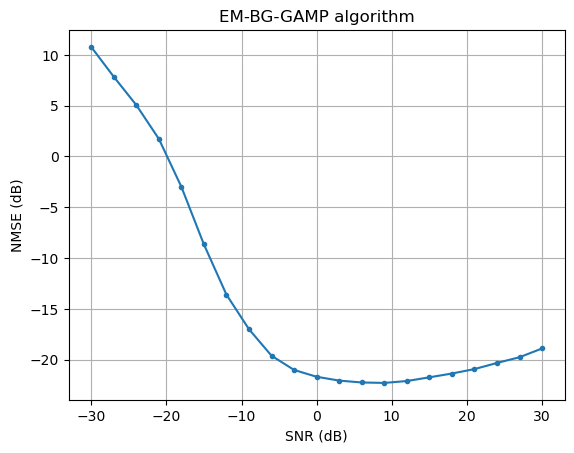

In [2]:
snrdb, nmse = gamp_curve.nmse_data()

plt.plot(snrdb, nmse, ".-")
plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("NMSE (dB)")
plt.title("EM-BG-GAMP algorithm")


## Read datasets with narrowband channels and show some channel matrices

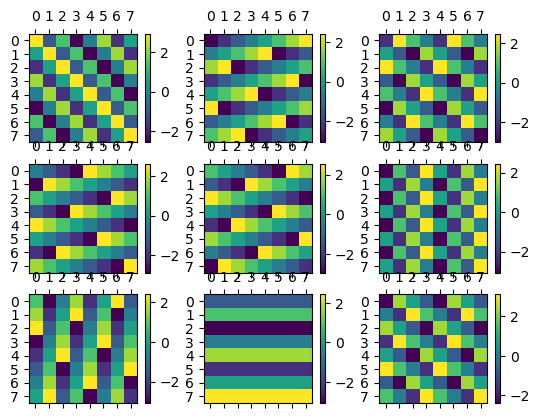

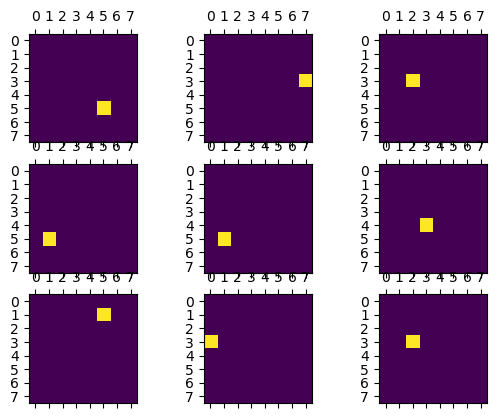

In [4]:
data = loadmat("./files_02_channel/random_sparse_channel_1000_8_8.mat")

antenna_channel, angle_channel = (data.get(key) for key in ["Harray", "Hvirtual"])
fig1, axs1 = plt.subplots(3, 3)
fig2, axs2 = plt.subplots(3, 3)
for i, ax in enumerate(axs1.flat):
    pos = ax.matshow(np.angle(antenna_channel[i]))
    fig1.colorbar(pos, ax = ax)
for i, ax in enumerate(axs2.flat):
    ax.matshow(np.abs(angle_channel[i]))



## Check that the matrices in array domain and virtual domain are related by the FFT

In [47]:
angle_ch = angle_channel[0] #get a matrix in virtual (or beamspace) domain
#convert to array domain using 2D FFT:
antenna_ch = np.fft.fft(
    np.fft.ifft(angle_ch, axis=-2, norm="ortho"), axis=-1, norm="ortho"
)
#show that the error is zero
print(f"sum = {np.sum(antenna_ch - antenna_channel[0])}")

sum = 0j


## Define a customized loss function in TF 2

In [48]:
def mse_db(y_true, y_pred):
    return (
        10
        * tf.math.log(tf.math.reduce_mean(tf.math.square(y_true - y_pred)))
        / math.log(10.0)
    )

## Auxiliary functions to define the DNN model

In [49]:
import numpy as np

def create_model(Nr, Nt, T, layers, should_include_x=True, should_normalize=True):
    norm_factor = np.sqrt(Nr * Nt)

    input_shape = (T, ((Nr + Nt) if should_include_x else Nr) * 2)
    output_shape = (2 * Nr, Nt)
    numOutputs = np.prod(output_shape)

    model = Sequential()
    # model.add(InputLayer(input_shape=input_shape))
    model.add(Lambda(lambda x: x, input_shape=input_shape))
    for layer in layers:
        model.add(layer)

    model.add(Dense(numOutputs, activation="linear"))
    if True:
        model.add(Lambda(lambda x: norm_factor * l2_normalize(x, axis=-1)))
    model.add(Reshape(output_shape))

    return model

def dense_model(
    Nr: int,
    Nt: int,
    T: int,
    num_neurons: list,
    activation: str = "relu",
    use_batch_norm: bool = False,
    dropout_rate: float = 0.0,
    should_include_x=True,
):

    layers = [Flatten()]

    for i, n in enumerate(num_neurons):
        layers.append(Dense(n, activation=activation))
        if use_batch_norm:
            layers.append(BatchNormalization())
        if dropout_rate != 0.0 and i != 0 and i != (len(num_neurons) - 1):
            layers.append(Dropout(dropout_rate))

    return create_model(Nr, Nt, T, layers, should_include_x=should_include_x)

def residual_model(Nr, Nt, T, num_neurons, activation="relu", should_include_x=True):
    norm_factor = np.sqrt(Nr * Nt)

    input_shape = (T, ((Nr + Nt) if should_include_x else Nr) * 2)
    output_shape = (2 * Nr, Nt)
    numOutputs = np.prod(output_shape)
    inputs = Input(input_shape)

    x0 = Flatten()(inputs)
    x1 = LeakyReLU()(Dense(num_neurons[0])(x0))
    for n in num_neurons[1:]:
        x0, x1 = x1, LeakyReLU()(Dense(n, activation=activation)(concatenate([x0, x1])))

    d_out = Dense(numOutputs, activation="linear")(concatenate([x0, x1]))

    reshape1 = Reshape(output_shape)(d_out)

    model = Model(inputs=inputs, outputs=reshape1)

    return model

## Define the DNN model

In [50]:
#from files_02_channel.low_res_mimo_ch_est.models import dense_model, residual_model
from tensorflow.keras.models import save_model, load_model

def get_model(Nr, Nt, T, model_type, should_include_x=False):
    if model_type == "dense":
        #specify number of neurons in hidden layers:
        num_neurons = [40, 30]#if want 10 layers with 256 neurons, each: [256 for _ in range(10)]
        return dense_model(
            Nr,
            Nt,
            T,
            num_neurons,
            should_include_x=should_include_x,
            activation="tanh",
        )
    elif model_type == "residual":
        #specify number of neurons in hidden layers:
        num_neurons = [40, 30]#if want 3 layers with 400 neurons, each: [400 for _ in range(3)]
        return residual_model(
            Nr, Nt, T, num_neurons, should_include_x=should_include_x
        )
    else:
        raise Exception("Invalid model name")


In [51]:
def train(filename, training_generator=None, validation_generator=None, epochs=100):
    model = load_model(filename, custom_objects={"mse_db": mse_db})
    model.compile(loss=mse_db, optimizer="adam")
    history = model.fit(
        x=training_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1,
        workers=1,
        use_multiprocessing=False,
        max_queue_size=16,
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                min_delta=5e-3,
                patience=9,
                restore_best_weights=True,
            ),
            ModelCheckpoint(
                filepath=filename,
                monitor="val_loss",
                verbose=1,
                save_best_only=True,
            ),
            ReduceLROnPlateau(
                factor=0.5,
                min_delta=5e-2,
                patience=3,
                cooldown=5,
                verbose=1,
                min_lr=1e-6,
            ),
            TensorBoard(histogram_freq=1),
        ],
    )

    return history


In [52]:
import files_02_channel.low_res_mimo_ch_est.snr_generator as snr_gen


def test_by_snr(model, snr, test_generator=None):
    test_generator.set_snr_generator(snr_gen.constant_snr(snr))
    return model.evaluate(test_generator)


def test(filename, test_generator, snr_db=[]):
    model = load_model(filename, custom_objects={"mse_db": mse_db})

    return [test_by_snr(model, snr, test_generator) for snr in snr_db]


In [53]:
from tensorflow import keras
from files_02_channel.low_res_mimo_ch_est.pilotgen.qpsk_pilot_gen import QpskPilotGenerator
from files_02_channel.low_res_mimo_ch_est.channelgen.random_sparse_gen import (
    RandomSparseChannelGenerator,
)

from files_02_channel.low_res_mimo_ch_est.XYGenerator import XYGenerator

rand_gen = np.random.Generator(np.random.SFC64())

Nr = 8 #number of receiver antennas
Nt = 8 #number of transmitter antennas
T = 40 #number of pilots for estimating the channel, original value = 256 to compare with GAMP baseline

should_include_x = False #include the transmitted pilots in the input tensor?

nn_topology = "residual" #use dense or residual

model = get_model(Nr, Nt, T, nn_topology, should_include_x=should_include_x)

model.compile(loss=mse_db, optimizer="adam")
model.summary()

model_graph_file_name = "./files_02_channel/nn_model_graph.png"
keras.utils.plot_model(model, model_graph_file_name, show_shapes=True)
print("Wrote file", model_graph_file_name)

filename = "model.h5"

save_model(model, filename)

x_generator = QpskPilotGenerator(Nt, T, rand_gen, is_constant=True)

snr_range = (0, 21) #SNR range in dB

num_clusters = 1 #number of non-zero entries in the beamspace (virtual) channel matrix
channel_generators = {
    name: RandomSparseChannelGenerator(Nr, Nt, num_clusters, rand_gen)
    for name in ["train", "val", "test"]
}

trainConfig = {
    "num_batches": 200,
    "batch_size": 32,
    "x_generator": x_generator,
    "channel_generator": channel_generators["train"],
    "snr_generator": snr_gen.uniform_snr(*snr_range, rand_gen),
    "quantizer": np.sign, #1-bit quantization
    "constant_batches": False,
    "should_include_x": should_include_x,
    "generator": rand_gen,
}

valConfig = {
    "num_batches": 20,
    "batch_size": 32,
    "x_generator": x_generator,
    "channel_generator": channel_generators["val"],
    "snr_generator": snr_gen.constant_snr(3),
    "quantizer": np.sign,
    "constant_batches": False,
    "should_include_x": should_include_x,
    "generator": rand_gen,
}

testConfig = {
    "num_batches": 100,
    "batch_size": 32,
    "x_generator": x_generator,
    "channel_generator": channel_generators["test"],
    "snr_generator": snr_gen.uniform_snr(*snr_range, rand_gen),
    "quantizer": np.sign,
    "constant_batches": False,
    "should_include_x": should_include_x,
    "generator": rand_gen,
}


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 40, 16)]     0           []                               
                                                                                                  
 flatten_3 (Flatten)            (None, 640)          0           ['input_4[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 40)           25640       ['flatten_3[0][0]']              
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 40)           0           ['dense_9[0][0]']                
                                                                                            

In [54]:
num_epochs = 10 #number of epochs
train(
    filename,
    training_generator=XYGenerator(**trainConfig),
    validation_generator=XYGenerator(**valConfig),
    epochs=num_epochs,
)


Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: -3.3627
Epoch 1: val_loss improved from inf to -4.36242, saving model to model.h5
200/200 [==============================] - 4s 18ms/step - loss: -3.3627 - val_loss: -4.3624 - lr: 0.0010
Epoch 2/10
197/200 [============================>.] - ETA: 0s - loss: -4.7093
Epoch 2: val_loss improved from -4.36242 to -5.00567, saving model to model.h5
200/200 [==============================] - 3s 14ms/step - loss: -4.7134 - val_loss: -5.0057 - lr: 0.0010
Epoch 3/10
197/200 [============================>.] - ETA: 0s - loss: -5.1443
Epoch 3: val_loss improved from -5.00567 to -5.20838, saving model to model.h5
200/200 [==============================] - 3s 16ms/step - loss: -5.1462 - val_loss: -5.2084 - lr: 0.0010
Epoch 4/10
196/200 [============================>.] - ETA: 0s - loss: -5.3069
Epoch 4: val_loss improved from -5.20838 to -5.34974, saving model to model.h5
200/200 [==============================] - 3s 15ms/step - loss

In [55]:
#See https://stackoverflow.com/questions/21809112/what-does-tuple-and-dict-mean-in-python
#for understanding **testConfig
nmse_db = test(
    filename,
    test_generator=XYGenerator(**testConfig),
    snr_db=np.arange(-30, 31, 3),
)


100/100 [==============================] - 1s 9ms/step - loss: -5.5926


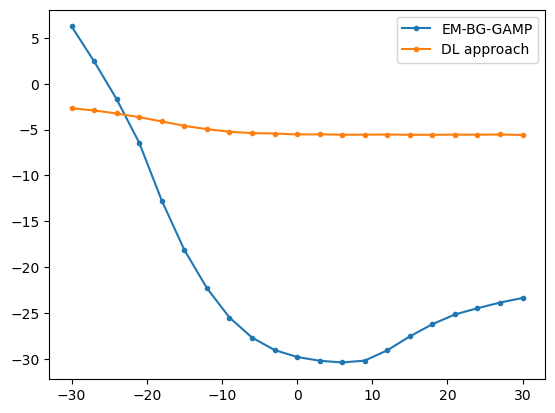

In [56]:
fig_res, ax_res = plt.subplots()
ax_res.plot(snrdb, nmse,'.-')
ax_res.plot(np.arange(-30, 31, 3), nmse_db, ".-")
ax_res.legend(["EM-BG-GAMP", "DL approach"])


## Authors

- [Marcos Yuichi Takeda - LASSE/UFPA](https://github.com/yuichitakeda)